# Project: Node Prediction for OGB-Arxiv using Curvature Graph Neural Networks

**CS224W: Machine Learning with Graphs**


_Stanford University. Winter, 2021._

---

**Team Members:** Gongqi Li, Khushal Sethi, Prathyusha Burugupalli

---
This colab implements Curvature Graph Network and Correct & Smooth for node prediction task on Ogb-Arxiv dataset.


## Environment Setup

In [4]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install ujson
!pip install ogb

     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for outdated: filename=outdated-0.2.0-cp37-none-any.whl size=4962 sha256=9acb7cb980e65c16f6510919c455db6c937392e7c4d65047d2e03b8f3d893ed9
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=fa5a52f9c6f0c2655464ed381eabd4fee7aa6916705aef205efa7f71fdb758d2
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built outdated littleutils


In [53]:
import torch
from torch.nn import Sequential as seq, Parameter, LeakyReLU, init, Linear
import torch.nn.functional as F
import numpy as np
import ujson
import json

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, MessagePassing
from torch_geometric.utils import add_self_loops, remove_self_loops, degree 
from torch_geometric.utils import softmax, to_undirected
from torch_sparse import SparseTensor

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from ast import literal_eval
from copy import deepcopy
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Baseline Model




#### GCN Model

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

#### SAGE Model


In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

## Curvature Graph Network

#### ConvGNN Model

In [19]:
class CurvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, curv_n, w_mul, bias=True):
        super(CurvGN, self).__init__(aggr='add') # "Add" aggregation.
        self.w_mul = w_mul
        self.lin = Linear(in_channels,out_channels)
        widths = [1, out_channels]
        self.w_mlp_out = create_wmlp(widths,out_channels, 1)
    def forward(self, x, edge_index):
        x = self.lin(x)
        out_weight = self.w_mlp_out(self.w_mul)
        out_weight = softmax(out_weight, edge_index[0])
        return self.propagate(x=x, edge_index=edge_index, out_weight=out_weight)
    def message(self, x_j, edge_index, out_weight):
        return out_weight*x_j
    def update(self, aggr_out):
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato,bias=lbias))

    return seq(*mlp_modules)

class ConvCurv(torch.nn.Module):
    def __init__(self, data, num_features, num_classes, 
                 hidden_channels, num_layers, w_mul, dropout, batch_norm):
        super(ConvCurv, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(CurvGN(num_features, 
                                 hidden_channels, hidden_channels, w_mul))

        if batch_norm:
            self.bns = torch.nn.ModuleList()
            for _ in range(num_layers - 1):
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(CurvGN(hidden_channels, 
                                 num_classes, num_classes, w_mul))

        self.dropout = dropout
        self.batch_norm = batch_norm

    def forward(self, data):
        x = data.x
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, data.edge_index)
            if self.batch_norm:
                x = self.bns[i](x)
            x = F.relu(x)
            F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, data.edge_index)

        return F.log_softmax(x, dim=-1)

def call(data, num_features, num_classes, hidden_channels, 
         num_layers, dropout, batch_norm):
    with open('curvature.txt') as file:
        forman_curvatures = ujson.load(file)

    ricci_cur = []
    for key, value in forman_curvatures.items():
        ricci_cur.append(literal_eval(key) + (value, ))
    ricci_cur = sorted(ricci_cur)
    w_mul = np.array([i[2] for i in ricci_cur])
    w_mul = (w_mul - np.mean(w_mul)) / np.std(w_mul)
    w_mul = list(w_mul)+[0 for i in range(data.x.size(0))]
    w_mul = torch.tensor(w_mul, dtype=torch.float)
    data.edge_index, _ = remove_self_loops(data.edge_index)
    data.edge_index, _ = add_self_loops(data.edge_index,
                                        num_nodes=data.x.size(0))
    data.w_mul = w_mul.view(-1, 1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data.w_mul = data.w_mul.to(device)
    model = ConvCurv(data, num_features, num_classes, 
                     hidden_channels, num_layers, 
                     data.w_mul, dropout, batch_norm).to(device)

    return model

## Training

#### Logger

In [16]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]
        self.verbose = info['verbose']

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            if self.verbose:
                print(f'Run {run + 1:02d}:')
                print(f'Highest Train: {result[:, 0].max():.2f}')
                print(f'Highest Valid: {result[:, 1].max():.2f}')
                print(f'Highest Test: {result[:, 2].max():.2f}')
                print(f'Final Train: {result[argmax, 0]:.2f}')
                print(f'Final Test: {result[argmax, 2]:.2f}')
            return result[argmax, 2]
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train1 = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                train2 = r[r[:, 2].argmax(), 0].item()
                test = r[r[:, 2].argmax(), 2].item()
                best_results.append((train1, valid, train2, test))

            best_result = torch.tensor(best_results)
            if self.verbose:
                print(f'All runs:')
            r = best_result[:, 0]
            if self.verbose:
                print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            if self.verbose:
                print(f'Highest Valid: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 2]
            if self.verbose:
                print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            if self.verbose:
                print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')
            return r.mean()

#### Training 

In [17]:
def experiment(args):

    def train(model, data, train_idx, optimizer, model_name):
      model.train()
      optimizer.zero_grad()
      if model_name == 'ConvGNN':
          out = model(data)[train_idx]
          loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
      else:
          out = model(data.x, data.adj_t)[train_idx]
          loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
      loss.backward()
      optimizer.step()
      return loss.item()
    
    @torch.no_grad()
    def test(model, data, split_idx, evaluator, model_name, mode='training'):

      if mode=='training':
          model.eval()
          if model_name == 'ConvGNN':
              out = model(data)
          else:
              out = model(data.x, data.adj_t)
      else:
          out = model
      y_pred = out.argmax(dim=-1, keepdim=True)
      train_acc = evaluator.eval({
          'y_true': data.y[split_idx['train']],
          'y_pred': y_pred[split_idx['train']],
      })['acc']
      valid_acc = evaluator.eval({
          'y_true': data.y[split_idx['valid']],
          'y_pred': y_pred[split_idx['valid']],
      })['acc']
      test_acc = evaluator.eval({
          'y_true': data.y[split_idx['test']],
          'y_pred': y_pred[split_idx['test']],
      })['acc']
      return train_acc, valid_acc, test_acc
    
    def process_adj(data):
        N = data.num_nodes
        data.edge_index = to_undirected(data.edge_index, data.num_nodes)

        row, col = data.edge_index

        adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
        deg = adj.sum(dim=1).to(torch.float)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        return adj, deg_inv_sqrt
    
    def gen_normalized_adjs(adj, D_isqrt):
        DAD = D_isqrt.view(-1,1) * adj * D_isqrt.view(1,-1)
        DA = D_isqrt.view(-1,1) * D_isqrt.view(-1,1)*adj
        AD = adj * D_isqrt.view(1,-1) * D_isqrt.view(1,-1)
        return DAD, DA, AD
  
    device = torch.device('cuda')
    evaluator = Evaluator(name='ogbn-arxiv')

    if args['model'] == 'ConvGNN':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv')
        data = dataset[0]
        adj, D_isqrt = process_adj(data)
        normalized_adjs = gen_normalized_adjs(adj, D_isqrt)
        DAD, DA, AD = normalized_adjs
        data.edge_index = to_undirected(data.edge_index, data.num_nodes)
    else:
        dataset = PygNodePropPredDataset(name='ogbn-arxiv',
                                         transform=T.ToSparseTensor())
        data = dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
    
    data = data.to(device)

    split_idx = dataset.get_idx_split()
    train_idx = split_idx['train'].to(device)

    if args['model'] == 'SAGE':
        model = SAGE(data.num_features, args['hidden_channels'],
                     dataset.num_classes, args['num_layers'],
                     args['dropout']).to(device)
    if args['model'] == 'GCN':
        model = GCN(data.num_features, args['hidden_channels'],
                    dataset.num_classes, args['num_layers'],
                    args['dropout']).to(device)

    logger = Logger(args['runs'], args)

    for run in range(args['runs']):
        if args['model'] == 'ConvGNN':
            model = call(data, data.x.size(1), dataset.num_classes, 
                         hidden_channels=args['hidden_channels'],
                         num_layers=args['num_layers'], 
                         dropout = args['dropout'],
                         batch_norm = args['batch_norm'])
        else:
            model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

        best_valid_acc = 0
        for epoch in range(1, 1 + args['epochs']):
            loss = train(model, data, train_idx, optimizer, args['model'])
            result = test(model, data, split_idx, evaluator, args['model'], mode="training")
            logger.add_result(run, result)
            train_acc, valid_acc, test_acc = result

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                best_model = deepcopy(model)

            if epoch % args['log_steps'] == 0:
                if args['verbose']:
                    print(f'Run: {run + 1:02d}, '
                          f'Epoch: {epoch:02d}, '
                          f'Loss: {loss:.4f}, '
                          f'Train: {100 * train_acc:.2f}%, '
                          f'Valid: {100 * valid_acc:.2f}% '
                          f'Test: {100 * test_acc:.2f}%')

        print('Training Results:')
        logger.print_statistics(run)
      
        model_out = best_model(data).cpu().exp()

        def error_correction(data, model_out, split_idx, S, alpha=0.98, iterations=10):
            # preprocessing
            labels = data.y.data.cpu()
            labels[labels.isnan()] = 0
            labels = labels.long()
            model_out = model_out.cpu()
            c = labels.max() + 1
            n = labels.shape[0]
            y = torch.zeros((n, c))
            y[split_idx['train']] = F.one_hot(labels[split_idx['train']],c).float().squeeze(1) - model_out[split_idx['train']]
            
            # iterations
            resid = y.clone()
            for i in range(iterations):
                resid = alpha * (S @ resid)
                resid += (1 - alpha) * y
                post_step = lambda x: torch.clamp(x, -1.0, 1.0)
                resid = post_step(resid).cpu()

            # autoscale
                orig_diff = y[split_idx['train']].abs().sum()/split_idx['train'].shape[0]
                resid_scale = (orig_diff / resid.abs().sum(dim=1, keepdim=True))
                resid_scale[resid_scale.isinf()] = 1.0
                cur_idxs = (resid_scale > 1000)
                resid_scale[cur_idxs] = 1.0
                res_result = model_out + resid_scale * resid
                res_result[res_result.isnan()] = model_out[res_result.isnan()]
                
                test_result = test(res_result, data, split_idx, evaluator, args['model'], mode="correct")
                logger.add_result(run, test_result)
                train_acc, valid_acc, test_acc = test_result
                if (i) % args['log_steps'] == 0:
                    if args['verbose']:
                        print(f'Run: {run + 1:02d}, '
                              f'Correcting: {i:02d}, '
                              f'Valid: {100 * valid_acc:.2f}% '
                              f'Test: {100 * test_acc:.2f}%')
            
            return res_result

        def smoothing(data, model_out, split_idx, S, alpha=0.65, iterations=10):
            # preprossing
            labels = data.y.data.cpu()
            model_out = model_out.cpu()
            c = labels.max() + 1
            n = labels.shape[0]
            y = model_out.clone()
            y[split_idx['train']] = F.one_hot(labels[split_idx['train']],c).float().squeeze(1)

            # iterations
            result = y.clone()
            for i in range(iterations):
                result = alpha * (S @ result)
                result += (1 - alpha) * y
                post_step = lambda x: torch.clamp(x, 0, 1)
                result = post_step(result).cpu()

                test_result = test(result, data, split_idx, evaluator, args['model'], mode="smooth")
                logger.add_result(run, test_result)
                train_acc, valid_acc, test_acc = test_result
                if (i) % args['log_steps'] == 0:
                    if args['verbose']:
                        print(f'Run: {run + 1:02d}, '
                              f'Smoothing: {i:02d}, '
                              f'Valid: {100 * valid_acc:.2f}% '
                              f'Test: {100 * test_acc:.2f}%')
            return result.cpu()

        if args['error_correction']:
            model_out = error_correction(data, model_out, split_idx, S=AD, alpha=args['alpha_correction'])
            print('Correcting Results: ')
            score = logger.print_statistics(run)

        if args['smoothing']:
            model_out = smoothing(data, model_out, split_idx, S=DA, alpha=args['alpha_smoothing'])
            print('Smoothing Results:')
            score = logger.print_statistics(run)

        del model, model_out
    score = logger.print_statistics()
    return score, logger



In [ ]:
torch.cuda.empty_cache()
args = {
    'log_steps': 1, 
    'model': 'ConvGNN',
    'num_layers': 3,   
    'hidden_channels': 128,
    'dropout': 0.0,
    'lr': 0.005,
    'epochs': 1000,
    'runs': 1,
    'error_correction': False,  ## if we want error correction during post-processing
    'smoothing': False,         ## if we want smoothing during post-processing
    'alpha_correction': 0.0,   ## alpha for error correction
    'alpha_smoothing': 0.0,   ## alpha for smoothing
    'batch_norm': True,
    'verbose': True
}
score, logger = experiment(args) 

#### Plot Training Curve

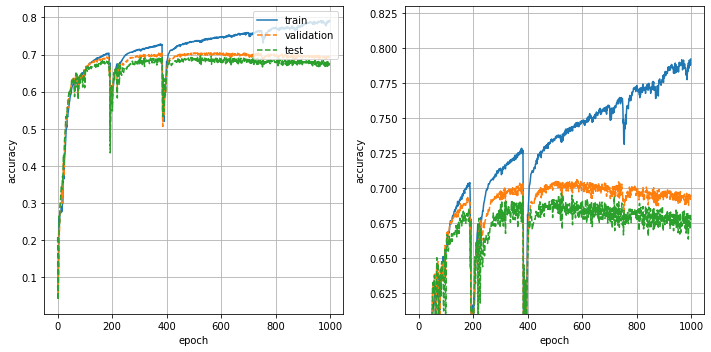

In [52]:
# Plot the training and validation curves
train_acc = np.array(logger.results[0])[:, 0]
val_acc = np.array(logger.results[0])[:, 1]
test_acc = np.array(logger.results[0])[:, 2]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_acc, label="train")
axs[0].plot(val_acc, ls='--', label="validation")
axs[0].plot(test_acc, ls='--', label="test")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("accuracy")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_acc, label="train")
axs[1].plot(val_acc, ls='--', label="validation")
axs[1].plot(test_acc, ls='--', label="test")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_ylim(bottom=val_acc[200])
axs[1].grid(True)

plt.tight_layout()

plt.savefig('learning_curve.png')

#### Hyperparameter Search

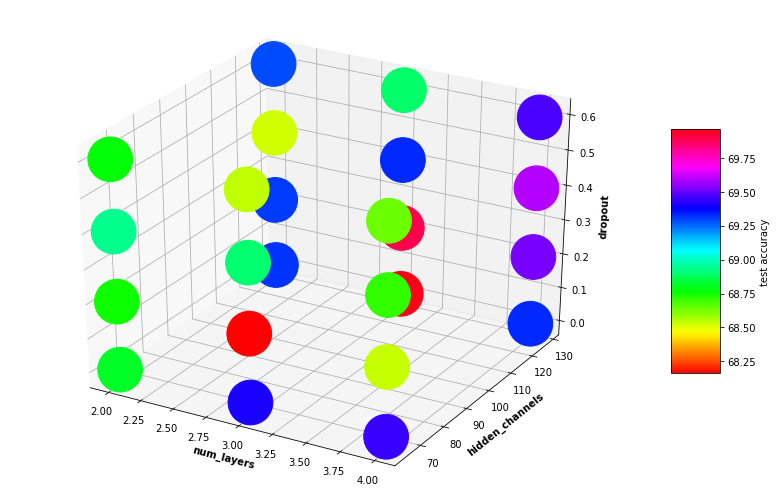

In [113]:
def grid_search():
    num_layers_range = [3]
    hidden_channels_range = [128]
    alpha_correction_range = [0.0, 0.0]
    alpha_smoothing_range = [0.5, 0.6, 0.7]

    
    best_score = 0
    best_params = {'num_layers': None,
                   'hidden_channels': None,
                   'alpha_correction': None,
                   'alpha_smoothing': None}
    for num_layers in num_layers_range:
        for hidden_channels in hidden_channels_range:
            for alpha_smoothing in alpha_smoothing_range:
                for alpha_correction in alpha_correction_range:
                    args = {
                        'log_steps': 1,
                        'model': 'ConvGNN',
                        'num_layers': num_layers,
                        'hidden_channels': hidden_channels,
                        'dropout': 0.2,
                        'lr': 0.005,
                        'epochs': 500,
                        'runs': 1,
                        'error_correction': True,
                        'smoothing': True,
                        'batch_norm': True,
                        'alpha_correction': alpha_correction,
                        'alpha_smoothing': alpha_smoothing,
                        'verbose': False
                    }
                    score = experiment(args)
                    if score > best_score:
                        best_params['num_layers'] = num_layers
                        best_params['hidden_channels'] = hidden_channels
                        best_params['alpha_correction'] = alpha_correction
                        best_params['alpha_smoothing'] = alpha_smoothing
                        best_score = score
                    print('Score: {}, Layers: {}, Hidden Channels: {}, Alpha Correction: {}, Alpha Smoothing: {}'
                    .format(score, num_layers, hidden_channels, alpha_correction, alpha_smoothing))
    return best_score, best_params

grid_search()

def generate_scatter_plot(x, y, z, c):
    fig = plt.figure(figsize = (14, 9))
    ax = plt.axes(projection ="3d")
    ax.grid(b = True, color ='grey', 
            linestyle ='-.', linewidth = 0.3, 
            alpha = 0.2)
    my_cmap = plt.get_cmap('hsv')
    sctt = ax.scatter3D(x, y, z,
                        alpha = 1,
                        c = c, 
                        cmap = my_cmap, 
                        marker ='o',
                        s=2000)
    ax.set_xlabel('num_layers', fontweight ='bold') 
    ax.set_ylabel('hidden_channels', fontweight ='bold') 
    ax.set_zlabel('dropout', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5, label='test accuracy')
    plt.savefig('scatter.png')

# x = np.concatenate([[2] * 8] + [[3] * 8] + [[4] * 8])
# y = np.concatenate([[64] * 4] + [[128] * 4] + [[64] * 4] + [[128] * 4] + [[64] * 4] + [[128] * 4])
# z = np.array([[0, 0.2, 0.4, 0.6] * 6])
# c = np.array([68.817, 68.753, 68.938, 68.777, 69.323, 69.31, 68.524, 69.294, 69.41, 68.16, 68.907, 
#      68.543,69.966,69.901,69.333,68.895,69.444,68.535,68.716,68.646,69.333,69.525,69.593,69.471])
# generate_scatter_plot(x, y, z, c)